In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'the-ultimate-earthquake-dataset-from-1990-2023:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3565867%2F6262076%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T090005Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D646bfc41011ca17a5c20f879cbf25e2e12f79922b63e10dbfc532627dafd95e7b899d25b907141aed28eeb9e5b1cc83d50c73b1b7eb6a6b4db359e1655f5d4762927c36e63c60e179c9edf7e597e99862a2760b68a9b1ddc03224bc2cf884fc604b070c88daaa553672cb2aa6e53c40bf6f262eaac37c2eacab85058c00a914d3483302449e61c3ee04fa35bf9f23912003379083990c660cee6279f9493e54ab6276d5e44afc10cbd71b281e0f6767d51445b799259b10ccb343b6c1af36715a223e66e55a46435116b99aa2aefaf677d513dee2e938bf23eb93fb221df757547931d231cb2ebba074861525eacba66117faaabdc2e02e93f7730b9ff251a21'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 121537542 bytes downloaded
Downloaded and uncompressed: the-ultimate-earthquake-dataset-from-1990-2023
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-ultimate-earthquake-dataset-from-1990-2023/Eartquakes-1990-2023.csv


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib

In [4]:
# Load the dataset
data_path = '/kaggle/input/the-ultimate-earthquake-dataset-from-1990-2023/Eartquakes-1990-2023.csv'
data = pd.read_csv(data_path)

In [5]:
# Exploratory Data Analysis (EDA)
print(data.head())
print(data.info())
print(data.describe())

           time                                 place    status  tsunami  \
0  631153353990     12 km NNW of Meadow Lakes, Alaska  reviewed        0   
1  631153491210            14 km S of Volcano, Hawaii  reviewed        0   
2  631154083450            7 km W of Cobb, California  reviewed        0   
3  631155512130  11 km E of Mammoth Lakes, California  reviewed        0   
4  631155824490                16km N of Fillmore, CA  reviewed        0   

   significance   data_type  magnitudo        state   longitude   latitude  \
0            96  earthquake       2.50       Alaska -149.669200  61.730200   
1            31  earthquake       1.41       Hawaii -155.212333  19.317667   
2            19  earthquake       1.11   California -122.806167  38.821000   
3            15  earthquake       0.98   California -118.846333  37.664333   
4           134  earthquake       2.95   California -118.934000  34.546000   

    depth                              date  
0  30.100  1990-01-01 00:22:

In [6]:
# Preprocess the data
# Create a target variable 'seismicity' based on magnitudo (magnitude)
# Define the bins and labels for the classification
bins = [0, 2.5, 5.5, 9.1]
labels = ['low', 'medium', 'high']
data['seismicity'] = pd.cut(data['magnitudo'], bins=bins, labels=labels)



In [7]:
# Drop rows with missing values
data = data.dropna()


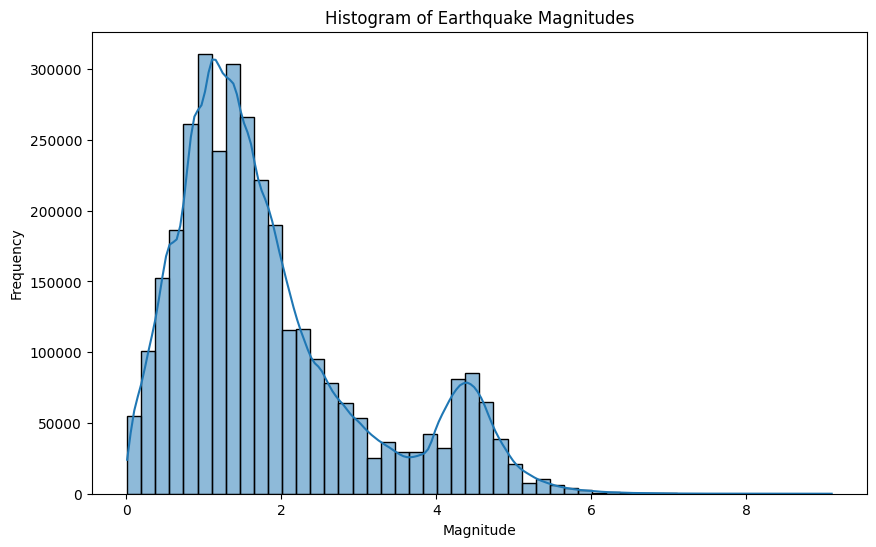

In [ ]:
# 1. Histogram of Earthquake Magnitudes
plt.figure(figsize=(10, 6))
sns.histplot(data['magnitudo'], bins=50, kde=True)
plt.title('Histogram of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()


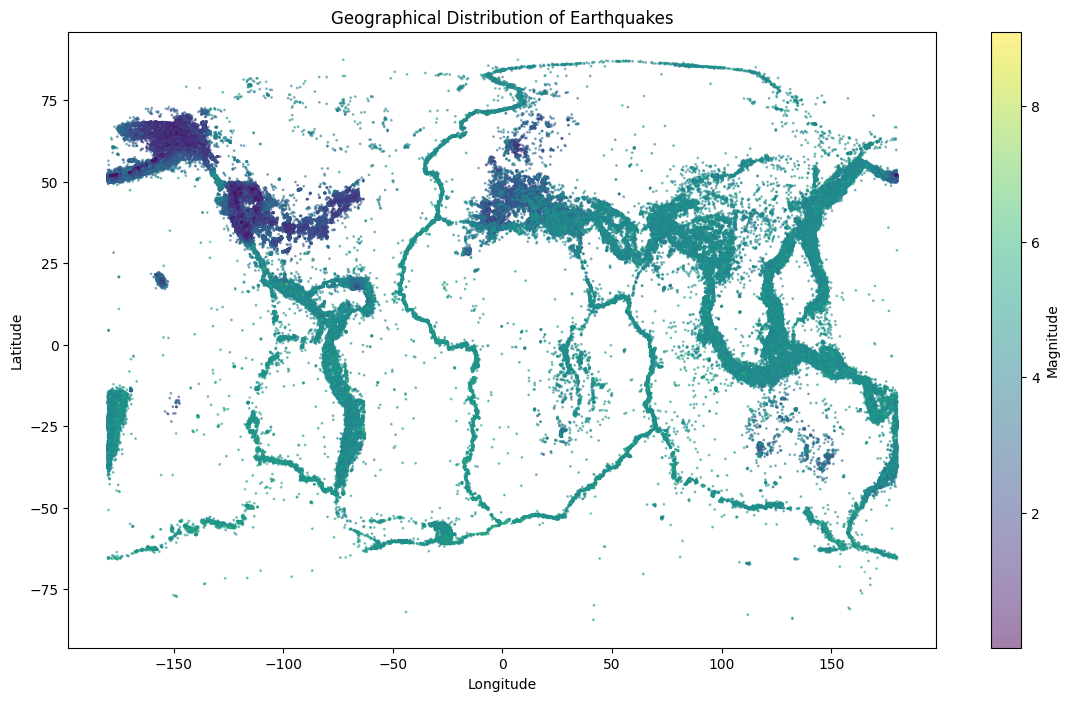

In [ ]:
# 2. Geographical Distribution of Earthquakes
plt.figure(figsize=(14, 8))
plt.scatter(data['longitude'], data['latitude'], alpha=0.5, c=data['magnitudo'], cmap='viridis', s=1)
plt.colorbar(label='Magnitude')
plt.title('Geographical Distribution of Earthquakes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

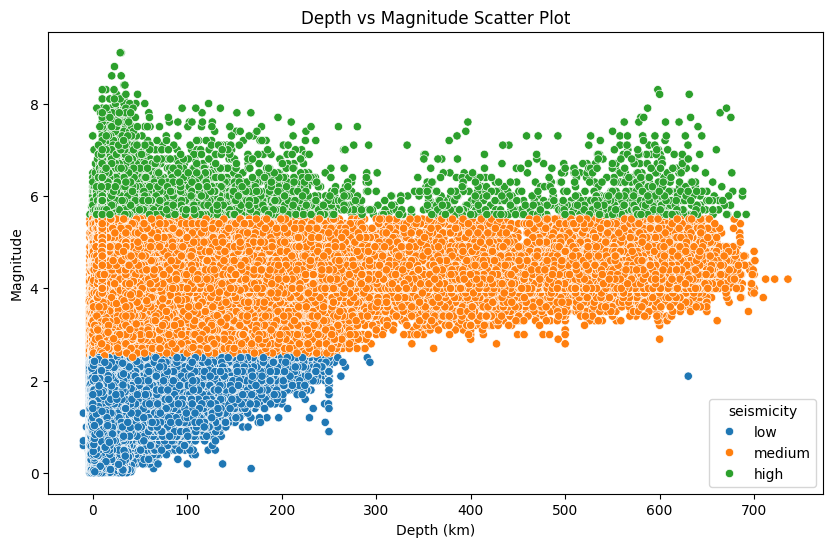

In [8]:
# 3. Depth vs Magnitude Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='magnitudo', data=data, hue='seismicity')
plt.title('Depth vs Magnitude Scatter Plot')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

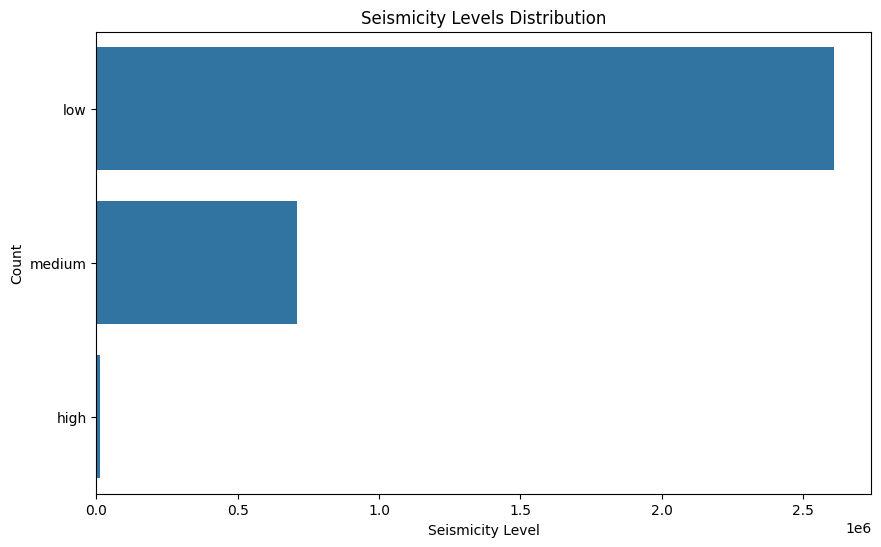

In [9]:
# 4. Seismicity Levels Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data['seismicity'])
plt.title('Seismicity Levels Distribution')
plt.xlabel('Seismicity Level')
plt.ylabel('Count')
plt.show()


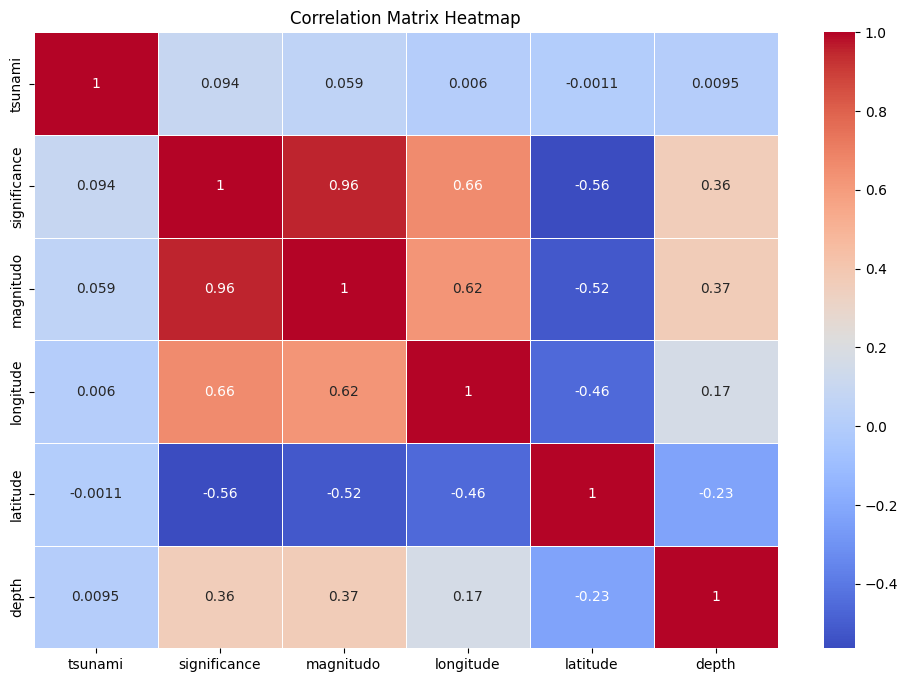

In [10]:
# 5. Correlation Matrix Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data[['tsunami', 'significance', 'magnitudo', 'longitude', 'latitude', 'depth']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
# Separate features and target variable
X = data.drop(['seismicity', 'time', 'place', 'status', 'data_type', 'date', 'state'], axis=1)
y = data['seismicity']

# Encode the target variable
y = y.astype('category').cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# SVM Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [14]:
# Evaluate the models
print("Naive Bayes Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

print("\nSVM Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

print("\nRandom Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Naive Bayes Classifier:
Accuracy: 0.9624868273974136
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    783443
           1       0.95      0.87      0.91    212908
           2       0.84      0.86      0.85      3831

    accuracy                           0.96   1000182
   macro avg       0.92      0.91      0.91   1000182
weighted avg       0.96      0.96      0.96   1000182


SVM Classifier:
Accuracy: 0.9994710962604806
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    783443
           1       1.00      1.00      1.00    212908
           2       1.00      1.00      1.00      3831

    accuracy                           1.00   1000182
   macro avg       1.00      1.00      1.00   1000182
weighted avg       1.00      1.00      1.00   1000182


Random Forest Classifier:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00

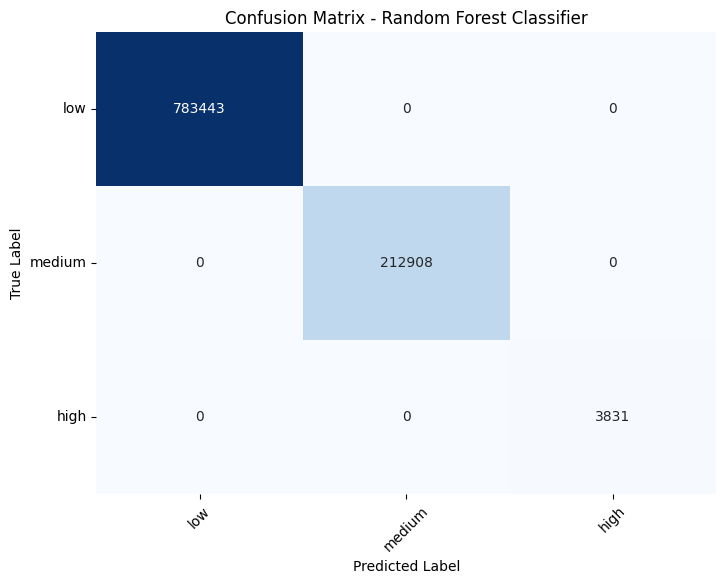

In [18]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Random Forest Classifier
rf_cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(rf_cm, labels, 'Random Forest Classifier')